## This Notebook is tasked with learning the kernel from some pinhole data. 
#### We do it in two stages. First we apply an affine transform model to get the kernel in the right location. Then we make regions of the kernel trainable and do further training. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd

from forward.fourier.kernel_creator import *
import scipy.ndimage
from skimage.transform import rotate

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2
device = 'cuda:2'

desired_range = [725,875]


4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


In [2]:
anadir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/20230906_1grating_pinhole_data_exptime_8000_us/'
positions = np.load(anadir + 'positions.npy')

In [3]:
dx = np.mean((positions[1:] - positions[:-1])) * 1e-3

In [4]:
dx

3.999799732977303e-08

In [5]:
resolution = 1000
E_0 = np.eye((resolution)) #position x wl
wls = np.linspace(725,875,resolution)

E_0[:,((wls<750) | (wls > 850))] = 0

In [6]:
I = np.zeros((len(positions), len(E_0)))

modfactors = np.zeros((len(positions), resolution))

pos = - dx * (len(positions)/2)



for i in range(len(positions)):
    modfactors[i] = np.cos(2*np.pi * 2*pos / (wls*1e-9))

    temp = E_0 * 0.5 * (1 + modfactors[i])
    
    I[i] = np.sum(temp**2, axis=-1)
    pos+=dx


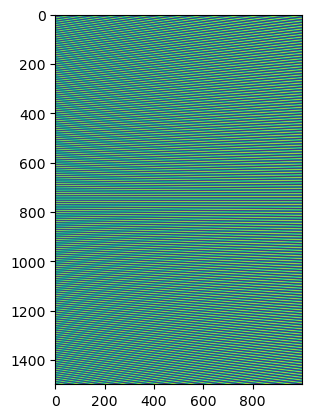

In [7]:
plt.imshow(modfactors)

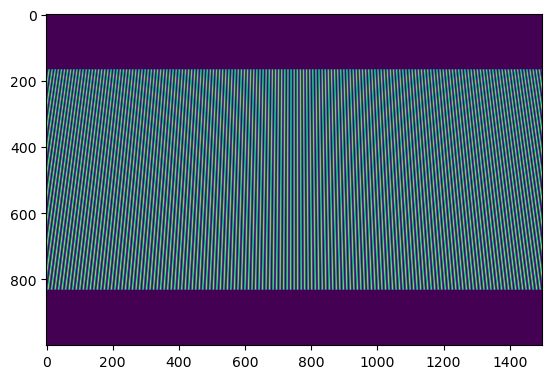

In [8]:
plt.imshow(I.T)

In [9]:
I.shape

(1499, 1000)

/tmp/user/25186/ipykernel_757026/563271111.py:7: RuntimeWarning: divide by zero encountered in divide
  wl_ = 3e8 / f


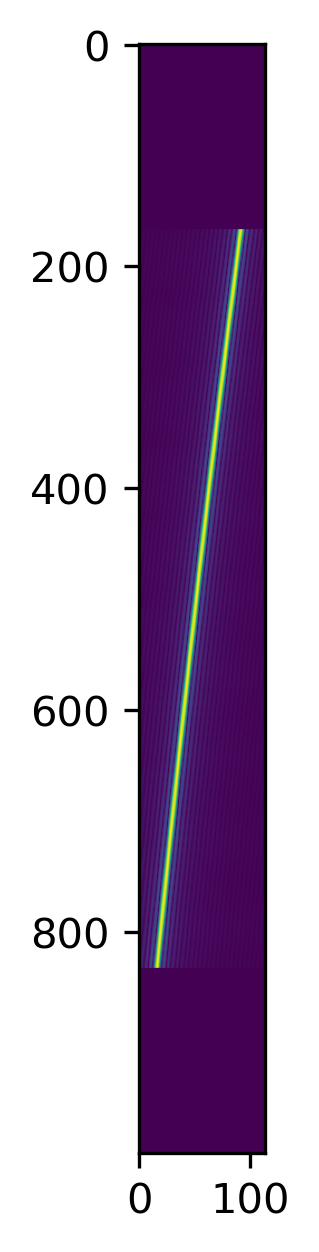

In [15]:
I_pad = np.zeros((6000, resolution))
I_pad[:len(positions)] = I

If = np.abs(np.fft.fft(I_pad, axis=0)).T # pos x wl
f = np.fft.fftfreq(len(I_pad), d=2*dx /3e8)

wl_ = 3e8 / f

If = If[:,((wl_ > 725e-9) & (wl_ < 875e-9))]

plt.figure(dpi=300)
plt.imshow(If)

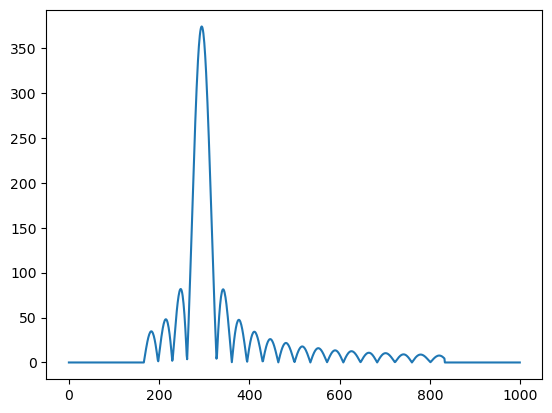

In [14]:
plt.plot(If[:,50])